In [1]:
import pg8000
conn = pg8000.connect(
    host="localhost", 
    database="CrimeData",  
    user="postgres",  
    password="14072003",  
    port="5432"
)

cursor = conn.cursor()
cursor.execute("SELECT * FROM crime_data")
rows = cursor.fetchall()
for row in rows:
    print(row)

cursor.close()
conn.close()


[1001, 'Burglary', 'Shenzhen', datetime.date(2024, 1, 1), datetime.time(0, 0), 63, 30, 'Unknown', Decimal('27.490800'), Decimal('103.702700')]
[1002, 'Fraud', 'Wuhan', datetime.date(2024, 1, 1), datetime.time(0, 1), 47, 59, 'Unknown', Decimal('39.014290'), Decimal('110.838000')]
[1003, 'Burglary', 'Beijing', datetime.date(2024, 1, 1), datetime.time(0, 2), 57, 20, 'Unknown', Decimal('34.639880'), Decimal('117.458900')]
[1004, 'Assault', 'Chongqing', datetime.date(2024, 1, 2), datetime.time(0, 4), 35, 26, 'Knife', Decimal('31.973170'), Decimal('114.644500')]
[1005, 'Assault', 'Shenzhen', datetime.date(2024, 1, 2), datetime.time(0, 5), 68, 29, 'None', Decimal('23.120370'), Decimal('116.131200')]
[1006, 'Theft', 'Guangzhou', datetime.date(2024, 1, 2), datetime.time(0, 7), 65, 40, 'Gun', Decimal('23.119890'), Decimal('113.175700')]
[1007, 'Vandalism', 'Shenzhen', datetime.date(2024, 1, 3), datetime.time(0, 8), 19, 31, 'Knife', Decimal('21.161670'), Decimal('113.845500')]
[1008, 'Burglary', 

In [2]:
columns = [desc[0] for desc in cursor.description]
import pandas as pd
df = pd.DataFrame(rows, columns=columns)

df.head()

,crime_id,crime_type,location,date,time,victim_age,suspect_age,weapon_use,latitude,longitude
0,1001,Burglary,Shenzhen,2024-01-01,00:00:00,63,30,Unknown,27.490800,103.702700
1,1002,Fraud,Wuhan,2024-01-01,00:01:00,47,59,Unknown,39.014290,110.838000
2,1003,Burglary,Beijing,2024-01-01,00:02:00,57,20,Unknown,34.639880,117.458900
3,1004,Assault,Chongqing,2024-01-02,00:04:00,35,26,Knife,31.973170,114.644500
4,1005,Assault,Shenzhen,2024-01-02,00:05:00,68,29,None,23.120370,116.131200


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [5]:
df.fillna(method='ffill', inplace=True)  

df['Date'] = pd.to_datetime(df['date'])

df.drop_duplicates(inplace=True)

print(df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   crime_id     1000 non-null   int64         
 1   crime_type   1000 non-null   object        
 2   location     1000 non-null   object        
 3   date         1000 non-null   object        
 4   time         1000 non-null   object        
 5   victim_age   1000 non-null   int64         
 6   suspect_age  1000 non-null   int64         
 7   weapon_use   1000 non-null   object        
 8   latitude     1000 non-null   object        
 9   longitude    1000 non-null   object        
 10  Date         1000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 93.8+ KB
None


In [6]:
df['Crime_Type'] = df['crime_type'].astype('category')

In [7]:
Q1 = df['victim_age'].quantile(0.25)
Q3 = df['victim_age'].quantile(0.75)
IQR = Q3 - Q1

outlier_condition = (df['victim_age'] < (Q1 - 1.5 * IQR)) | (df['victim_age'] > (Q3 + 1.5 * IQR))

df = df[~outlier_condition]

print(df.shape)


(1000, 12)


In [8]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Day_of_Week'] = df['Date'].dt.day_name()


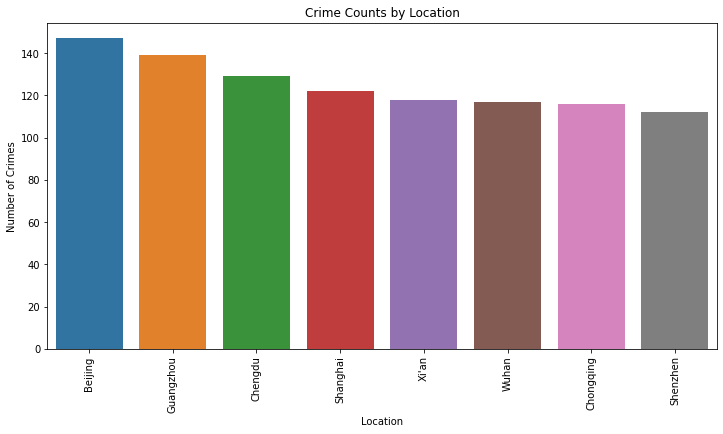

In [9]:
crime_counts = df['location'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=crime_counts.index, y=crime_counts.values)
plt.xticks(rotation=90)
plt.title('Crime Counts by Location')
plt.xlabel('Location')
plt.ylabel('Number of Crimes')
plt.show()


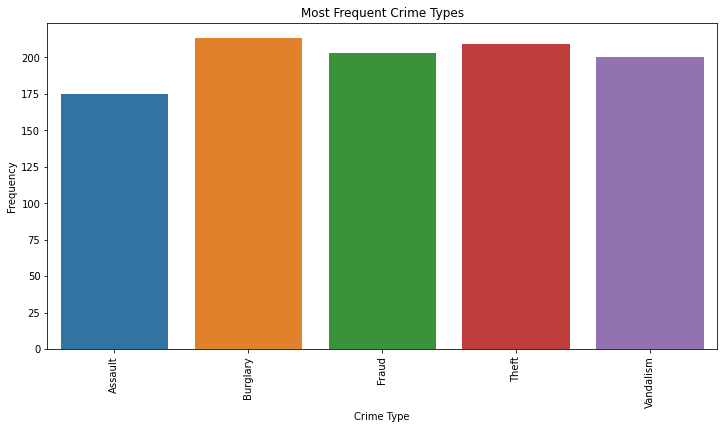

In [10]:
crime_type_counts = df['Crime_Type'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=crime_type_counts.index, y=crime_type_counts.values)
plt.xticks(rotation=90)
plt.title('Most Frequent Crime Types')
plt.xlabel('Crime Type')
plt.ylabel('Frequency')
plt.show()


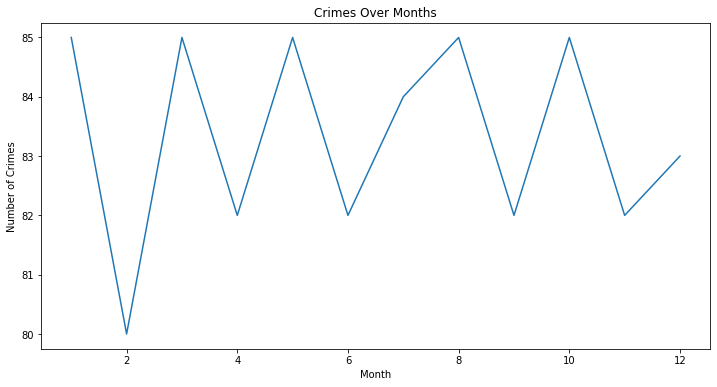

In [11]:
monthly_crimes = df['Month'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_crimes.index, y=monthly_crimes.values)
plt.title('Crimes Over Months')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.show()


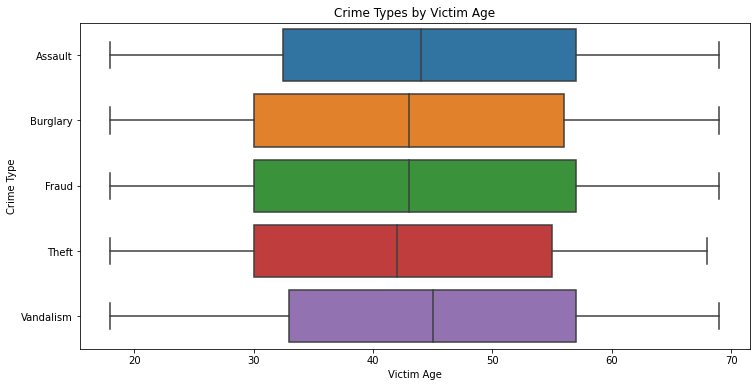

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='victim_age', y='Crime_Type', data=df)
plt.title('Crime Types by Victim Age')
plt.xlabel('Victim Age')
plt.ylabel('Crime Type')
plt.show()


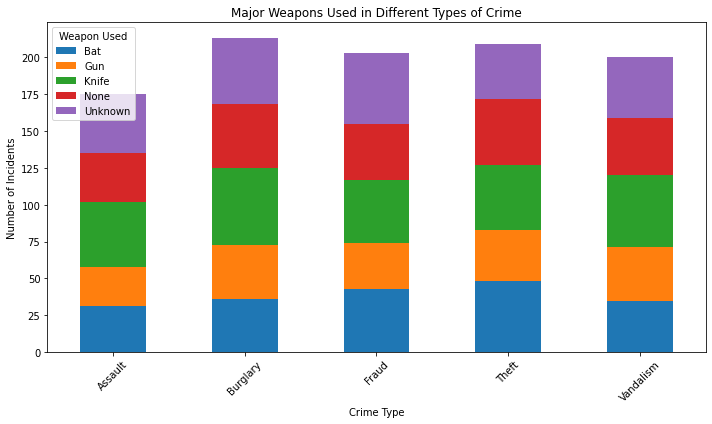

In [16]:
# Count occurrences of each weapon by crime type
weapon_counts = df.groupby(['Crime_Type', 'weapon_use']).size().reset_index(name='Counts')

# Pivot the DataFrame to have weapons as columns
pivot_table = weapon_counts.pivot(index='Crime_Type', columns='weapon_use', values='Counts').fillna(0)

# Plotting the data
pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Major Weapons Used in Different Types of Crime')
plt.xlabel('Crime Type')
plt.ylabel('Number of Incidents')
plt.legend(title='Weapon Used')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
X = df[['latitude', 'longitude', 'victim_age']] 
y = df['crime_type'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

     Assault       0.19      0.19      0.19        37
    Burglary       0.17      0.20      0.18        41
       Fraud       0.22      0.21      0.21        43
       Theft       0.29      0.27      0.28        45
   Vandalism       0.14      0.15      0.14        34

    accuracy                           0.20       200
   macro avg       0.20      0.20      0.20       200
weighted avg       0.21      0.20      0.21       200

[[ 7  8  9  6  7]
 [ 9  8  6 10  8]
 [ 5 12  9  7 10]
 [ 8 10 10 12  5]
 [ 7  8  7  7  5]]


C:\Users\rupik\anaconda3\envs\Tensorflow\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  f"KMeans is known to have a memory leak on Windows "


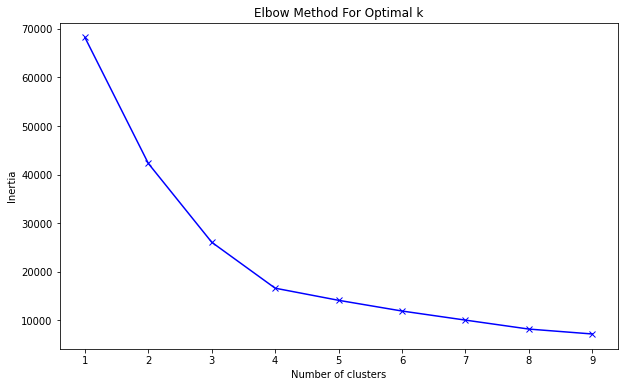

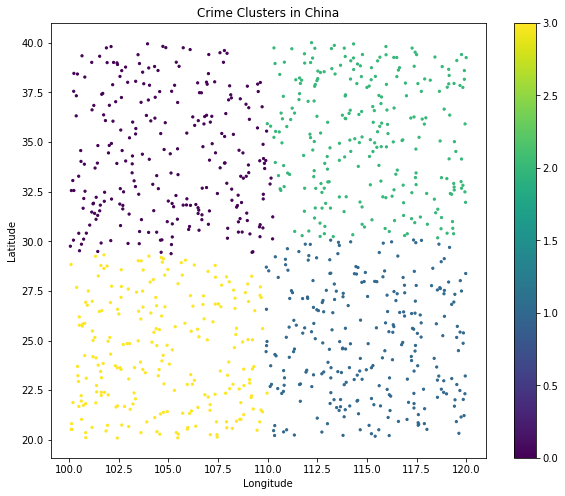

In [15]:
if 'latitude' in df.columns and 'longitude' in df.columns:
    X = df[['latitude', 'longitude']].dropna()
    inertia = []
    K = range(1, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state = 42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    optimal_k = 4
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df['Cluster'] = kmeans.fit_predict(X)

    # Plot Clusters
    gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.longitude, df.latitude))
    gdf.plot(column='Cluster', cmap='viridis', markersize=5, figsize=(10,8), legend=True)
    plt.title('Crime Clusters in China')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
else:
    print("Dataset does not contain 'Latitude' and 'Longitude' columns.")